In [1]:
from glob import glob
import os
import shutil
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import geopandas as gpd

all_month_counts = {}
coords = []

conn = sqlite3.connect("images.db")
c = conn.cursor()

n_images_per_class = 250

class_file_path = "./iNaturalist/images/Poison Ivy/classes.txt"

for line in open(class_file_path):
    the_label = line.strip()
    print(the_label)
    i = 0
    record_ids = set()
    plant_month_counts = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0}
    
    pattern = "./iNaturalist/images/" + the_label + "/*.txt"
    labels = glob(pattern)
    labels.remove("./iNaturalist/images/" + the_label + "\\classes.txt")
    
    for coords_path in labels:
        if i < n_images_per_class:
            i += 1
            record_id = int(coords_path.split("\\")[-1].split(".txt")[0])
            record_ids.add(record_id)
        else:
            break
    
    c.execute("SELECT * FROM images WHERE label LIKE '" + the_label + "'")
    for row in c.fetchall():
        if row[0] in record_ids:
            date = row[6]
            try:
                month = int(date.split("-")[1])
            except:
                month = None
            coords.append({"Plant Type":the_label, "lat":row[4], "lon":row[5]})        
            plant_month_counts[month] = plant_month_counts.get(month, 0) + 1
    all_month_counts[the_label] = plant_month_counts

Poison Ivy
Virginia Creeper
Bramble
Box Elder


In [2]:
all_month_counts_df = []
for k,v in all_month_counts.items():
    for k2,v2 in v.items():
        all_month_counts_df.append({"Plant Type":k, "Month":k2, "Images":v2})
all_month_counts_df = pd.DataFrame(all_month_counts_df)

coords_df = pd.DataFrame(coords)

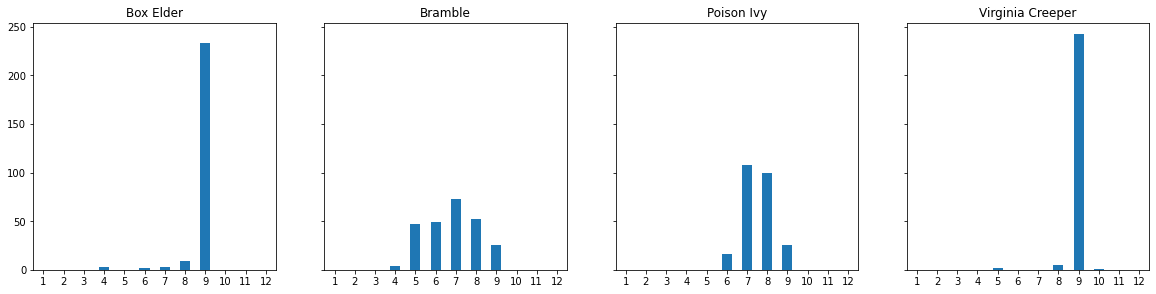

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=4, sharey=True, figsize=(20, 10))
axes_list = [item for sublist in axes for item in sublist] 

for plant_type, selection in all_month_counts_df.groupby("Plant Type"):
    ax = axes_list.pop(0)
    selection = selection.sort_values(by=["Month"])
    selection.plot.bar(x="Month", y="Images", ax=ax, rot=0, legend=False, label=plant_type);
    ax.set_title(plant_type)
    ax.set_xlabel("")
for ax in axes_list:
    ax.remove()

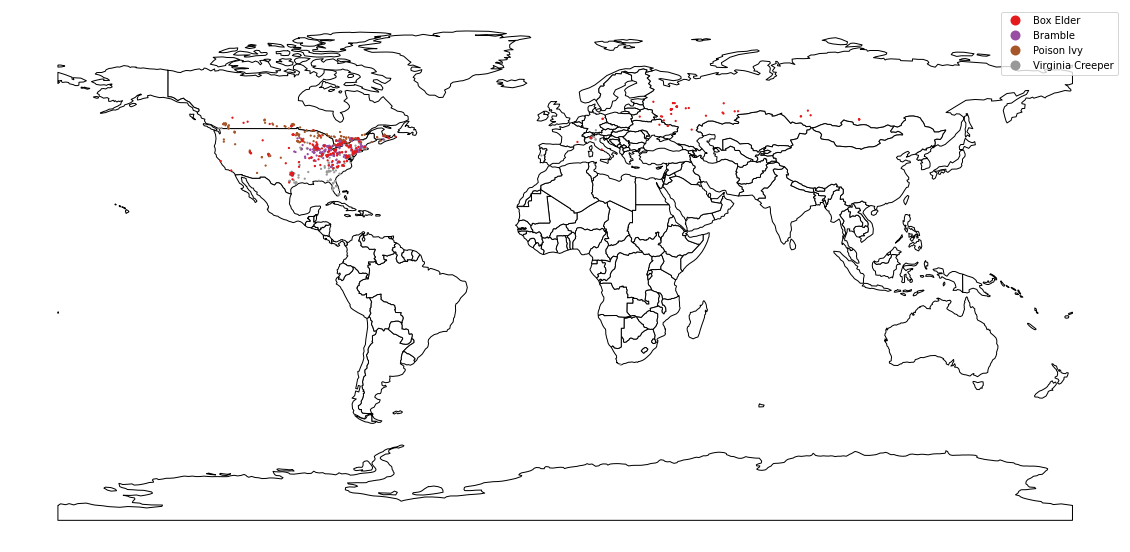

In [4]:
brewer_cmap = cm.get_cmap("Set1")
gdf = gpd.GeoDataFrame(coords_df, geometry=gpd.points_from_xy(coords_df.lon, coords_df.lat))
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
fig, ax = plt.subplots(figsize=(20, 20))
world.plot(color="white", edgecolor="black", ax=ax)
gdf.plot(column='Plant Type', categorical=True, legend=True, ax=ax, markersize=1.5, cmap=brewer_cmap)
ax.set_axis_off()
plt.show()

In [5]:
all_month_counts_df.to_csv("report/all_month_counts.csv", index=False)
coords_df.to_csv("report/coords.csv", index=False)